# <div style="text-align: center">  Code Assigment 1  </div> 


<img src="https://blogs.elespectador.com/wp-content/uploads/2017/09/logo-Universidad-Nacional.png" 
     style="float: right; margin-right: 10px;" 
     width="120"
     />

<div style="text-align: left"> 
Edison David Serrano Cárdenas. <br>
Student of Mathematics and Computer Sciences. <br>
Universidad Nacional de Colombia - Sede Bogotá <br>
</div>


For this assignment we will use the following SVM implementation for classifying these datasets: 
- https://archive.ics.uci.edu/ml/datasets/banknote+authentication 
- https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

You should:

- [x] Specify which Machine Learning problem are you solving.

- [x] Provide a short summary of the features and the labels you are working on.

- [ ] Please answer the following questions: 
		- [ ] Are these datasets linearly separable?
        		- Convex hull each label set  are disjoint.
        - [ ] Are these datasets randomly chosen.
        		- Ver los histogramas.
                - Ver comportamiento de cada una de las muestras.
                - test: https://predictivehacks.com/how-to-test-for-randomness/,  
                        https://stats.stackexchange.com/questions/256417/single-index-to-measure-the-randomness-of-multivariate-distributions-or-data
        - [ ] The sample size is enough to guarantee generalization.


- [ ] Provide an explanation how and why the code is working. You can add comments and/or formal explanations into the notebook.

- [x] Show some examples to illustrate that the method is working properly.

- [ ] Provide quantitative evidence for generalization using the provided dataset.

	- Dividir los datos, training and testing sets. 80-20.
    - Se ajustan los parametros del modelo con train.
    - Se evalua el rendimiento.

**Load Libraries:**

In [52]:
# Basic libraries.
import numpy as np
import pandas as pd
import zipfile
from pathlib import Path
import urllib.request
import numpy as np

# Optimization
from scipy.optimize import linprog

# Machine Learning Models and Metrics.
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Visualization libraries.
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Machine Learning Problem

In this notebook we going to solve a suppervised learning problem,to be more specific a binary classification task. The dataset provide us a set of features and labels, and our objetive is give to a new un-observed data their associated label.

## Data Description 

- [ ] Banknote Authentication Data Set
	- [x]  Summary
    - [x]  Alinearly separable 
    - [ ]  datasets randomly chosen
    - [ ]  guarantee generalization
- [ ] Occupancy Detection Data Set
	- [x]  Summary
    - [x]  Alinearly separable 
    - [ ]  datasets randomly chosen
    - [ ]  guarantee generalization

### Banknote Authentication Data Set

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Currencies_on_White_Background.jpg/440px-Currencies_on_White_Background.jpg" 
     style="float: right; margin-right: 10px;" 
     width="300"
     />
**Abstract:** 
<!---
Data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes.
--->
A set of images taken from genuine and forged banknote-like specimens is created. Features such as wavelet variance, wavelet skewness, wavelet kurtosis, and image entropy are extracted from the images.

The label which we are working are counterfeit and non-counterfeit.

The number of instances in the data set is 1372, and the number of variables is 5 (4 features, 1 label). The 55.5% of the instances are non-counterfeit records and 44.5% are counterfeit records.



**Attributes:**

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)


**Note:** To understand how Wavelet transform works, the  video [Wavelets: a mathematical microscope](https://www.youtube.com/watch?v=jnxqHcObNK4) present an interesting approach.

In [107]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", 
                 sep = ',', 
                 header = None, 
                 names=["variance_of_Wavelet","skewness_of_Wavelet",
                        "curtosis_of_Wavelet","entropy",
                        "class"],
                 thousands = ',')
variables=["variance_of_Wavelet","skewness_of_Wavelet", "curtosis_of_Wavelet","entropy"]

In [24]:
print("Dimensionality of the Dataframe:",df.shape)

Dimensionality of the Dataframe: (1372, 5)


In [25]:
print("Class Percentage:")
df["class"].value_counts(normalize=True)

Class Percentage:


0    0.555394
1    0.444606
Name: class, dtype: float64

**Scatter Matrix:**

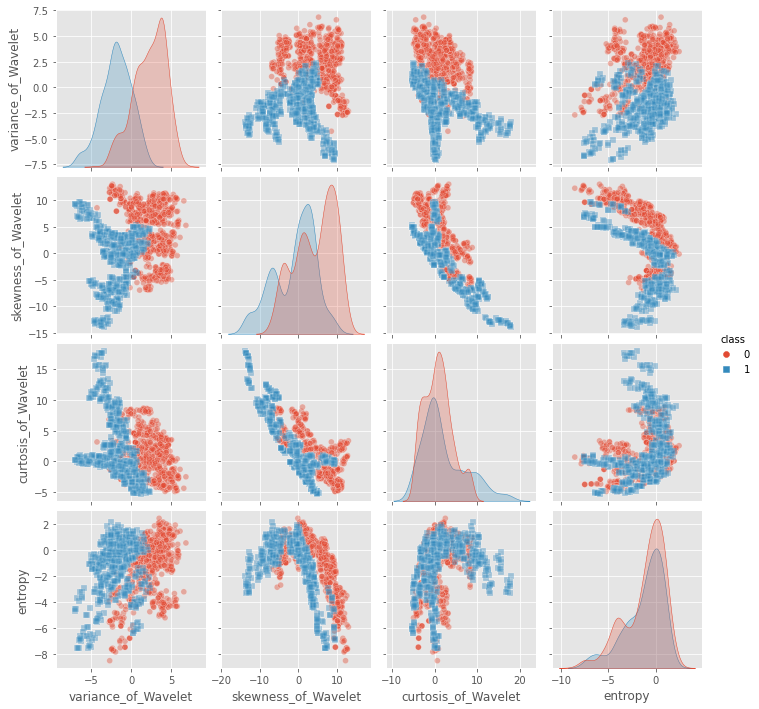

In [40]:
sns.pairplot(df, hue="class",plot_kws={'alpha':0.4},markers=["o", "s"])
plt.show()

#### Convex Hull to analyze Linearly-separable

**Proposition:** Two sets are linearly separable if and only if their convex hulls don’t
intersect, [AM 221: Advanced Optimization - Yaron Singer - 3.1 Separability](https://people.seas.harvard.edu/~yaron/AM221-S16/lecture_notes/AM221_lecture13.pdf).

Keeping this in mind, to determine if a point $x$ belong to the convex hull of the points $\{p_1,p_2,\cdots,p_k\}$, it's enough determine if exist a convex combination of the points equal to the point $x$, in other words, there is a non-negative vector $\lambda\in\mathbb{R}^k$, such that,

$$\sum_{i} p_{i}^T\lambda_i=x \text{    and    } \sum_j \lambda_j=1$$

The function *in_hull* use the previous idea to determine if a point $x$ belong to the convex hull of $\{p_i\}_{1\leq i\leq k}$, analysing if a linear programming problem is feasible.

In [48]:
def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b,bounds=(0, None))
    return lp.success

The two sets of each class are finite, so to determine if the convex hull does not intersect it is enough show that for any point of a class do not belong to the convex hull of the other class.

In [118]:
df_0 = df[df["class"]==0][variables]
df_1 = df[df["class"]==1][variables]

In [9]:
r=0
for i in range(df_1.shape[0]): #
    if in_hull(df_0.to_numpy(), df_1.iloc[i]):
        r=r+1
for i in range(df_0.shape[0]):
    if in_hull(df_1.to_numpy(), df_0.iloc[i]):
        r=r+1

In [10]:
print("Porcentage:",r/df.shape[0]*100,"%")

Porcentage: 0.0 %


#### Linear Separability with Linear Programming

In [132]:
def lp_linearly_sep(points_1,points_2):
    
    A1 =  np.concatenate((-points_1,np.ones((len(points_1),1))),axis=1)
    A2 = np.concatenate((points_2,- np.ones((len(points_2),1))),axis =1)
    
    A = np.concatenate((A1,A2))
    b=np.full(len(A),-1)
    c=np.zeros(len(A1[0]))
    
    lp = linprog(c, A_ub=A, b_ub=b)
    
    return lp.success

In [133]:
lp_linearly_sep(points_1,points_2)

True

In [134]:
lp_linearly_sep(df_1,df_0)

False

In [127]:
points_1 = np.array([[1,7],[2,8],[3,8]])
points_2 = np.array([[5,1],[6,-1],[7,3]])

### Occupancy Detection Data Set

<img src="https://www.trueoccupancy.com/hubfs/Occupancy%20Sensors%20-%20Room%20Sensors%20-%20600x315.png" 
     style="float: right; margin-right: 10px;" 
     width="300"
     />
**Abstract:** 

Experimental data used for binary classification (room occupancy) from Temperature,Humidity,Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.

The number of instances in the data set is 20560, and the number of variables is 7.

**Attribute Information:**

- date time year-month-day hour:minute:second
- Temperature, in Celsius
- Relative Humidity, %
- Light, in Lux
- CO2, in ppm
- Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
- Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status


In [11]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

def load_occupacy_data():
    tarball_path = Path("datasets/occupancy_data.zip")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip"
        urllib.request.urlretrieve(url, tarball_path)
        with zipfile.ZipFile(tarball_path) as occupancy_tarball:
           # open the csv file in the dataset
           occupancy_tarball.extractall(path="datasets")
    list_df =[pd.read_csv(Path("datasets/datatraining.txt"),parse_dates=['date'],date_parser=dateparse),
              pd.read_csv(Path("datasets/datatest.txt"),parse_dates=['date'],date_parser=dateparse),
              pd.read_csv(Path("datasets/datatest2.txt"),parse_dates=['date'],date_parser=dateparse),]
    return list_df

In [ ]:
train, test1, test2= load_occupacy_data()

The variable date is not a numeric variable. We going to analyse their behaviour to propose a transformation of this variable to a numeric variable.

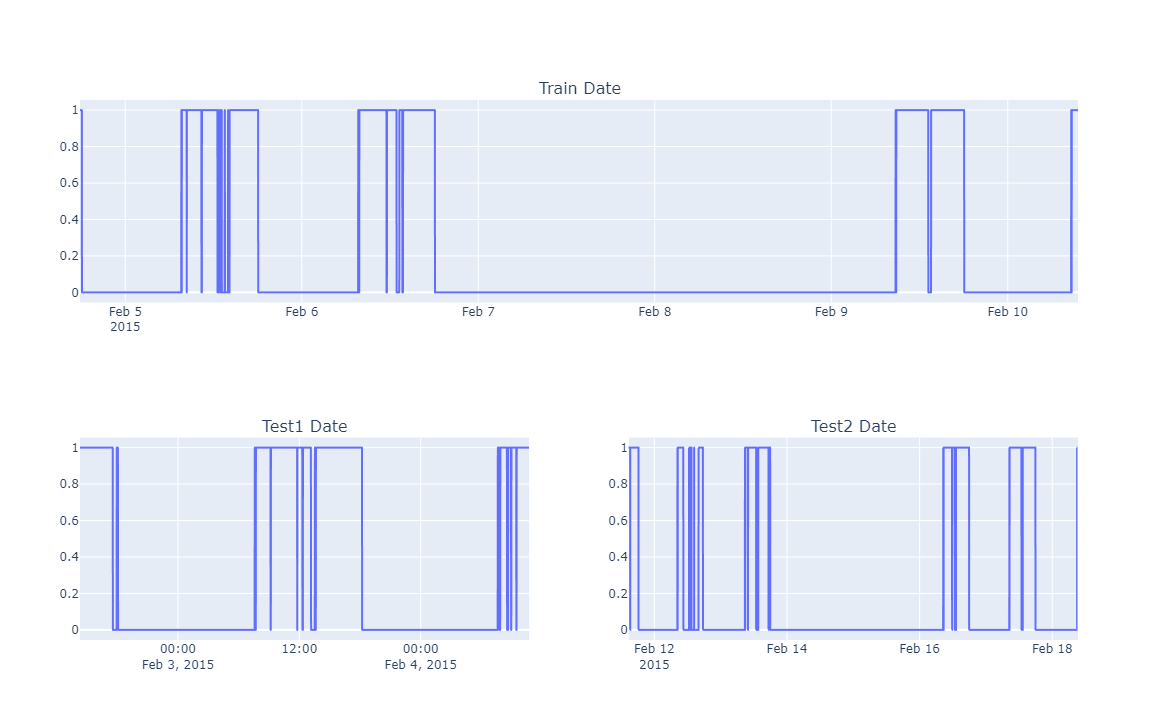

In [92]:
figures = [ px.line(train, x='date', y="Occupancy",
                 width=800, height=400),
            px.line(test1, x='date', y="Occupancy",
                 width=800, height=400),
            px.line(test2, x='date', y="Occupancy",
                         width=800, height=400) ]

fig = make_subplots(rows=2, cols=2,
                    specs=[[{"colspan": 2}, None],[{}, {}]],
                    subplot_titles=("Train Date","Test1 Date", "Test2 Date")) 

fig.append_trace(figures[0]["data"][trace], row=1, col=1)
fig.append_trace(figures[1]["data"][trace], row=2, col=1)
fig.append_trace(figures[2]["data"][trace], row=2, col=2)

fig.show()

The previous graphs tell us that it is important the day, hour and minutes to describe the two categories. The day has relevant information if is o not a holiday, is normal think that in holidays there is low occupacy, the hour and minutes help us to describe the begining and end of the journey.

**Date Transformation:** We going to convert the date to years unit. For example: 2015-02-04 17:51:00 it is converted to 2015.179663. The month could be irrelevant by the train data time period, but it is include in the analysis.

In [101]:
train['date_numeric'] = train['date'].apply(lambda time: time.year+time.month/12+ time.day/365 + time.hour/8760+time.minute/525600)
test1['date_numeric'] = test1['date'].apply(lambda time: time.year+time.month/12+ time.day/365 + time.hour/8760+time.minute/525600)
test2['date_numeric'] = test2['date'].apply(lambda time: time.year+time.month/12+ time.day/365 + time.hour/8760+time.minute/525600)

In [155]:
variables2 = ['date_numeric', 'Temperature', 'Humidity', 'Light', 
              'CO2', 'HumidityRatio', 'Occupancy']

**Scatter Matrix:**

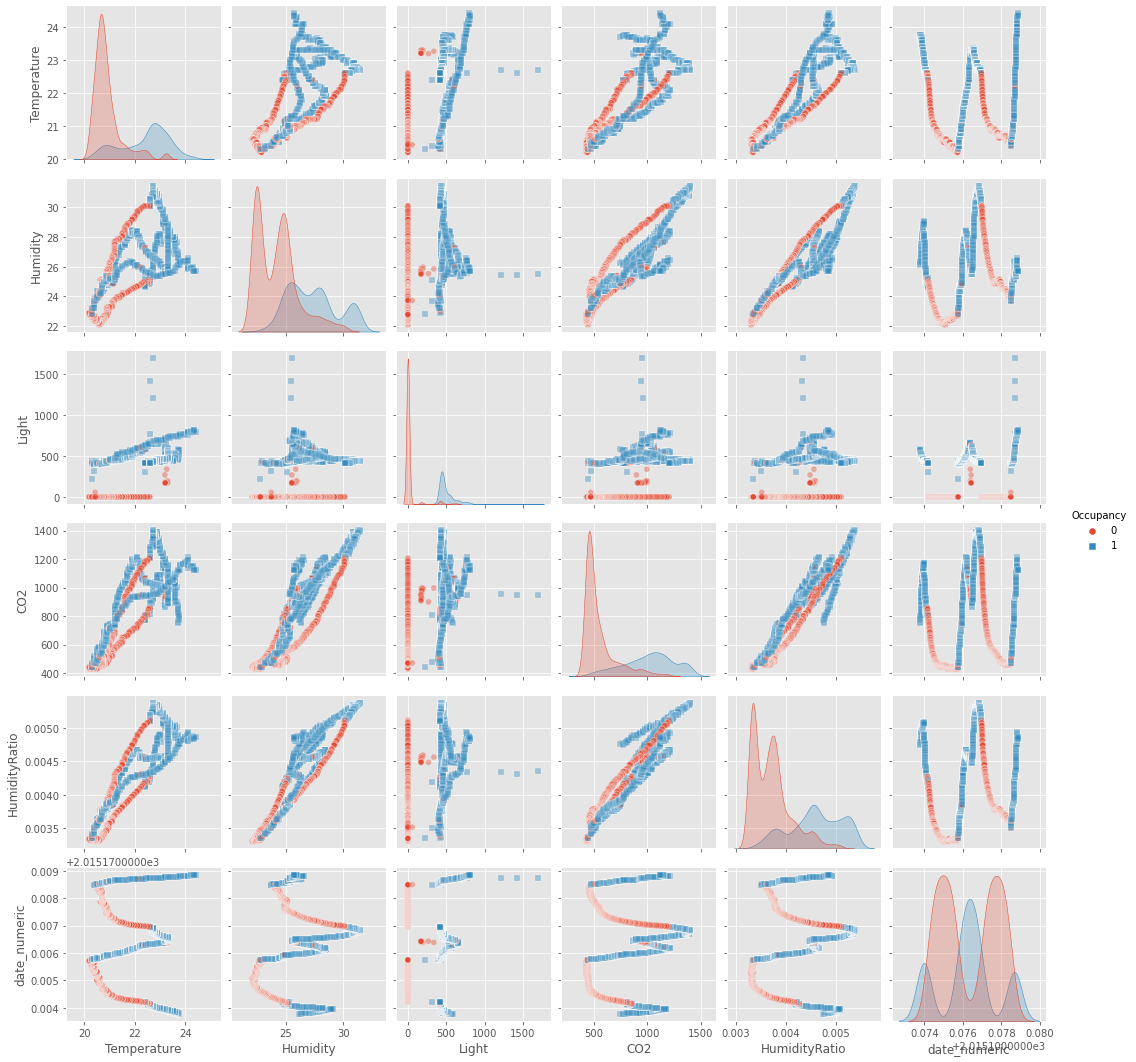

In [156]:
sns.pairplot(test1, hue='Occupancy',plot_kws={'alpha':0.4},markers=["o", "s"])
plt.show()

### Convex Hull to analyze Linearly-separable

In [103]:
train_0 = train[train["Occupancy"]==0][variables2]
train_1 = train[train["Occupancy"]==1][variables2]

In [105]:
r=0
for i in range(train_1.shape[0]):
    if in_hull(train_0.to_numpy(), train_1.iloc[i]):
        r=r+1
for i in range(train_0.shape[0]):
    if in_hull(train_1.to_numpy(), train_0.iloc[i]):
        r=r+1

C:\Users\DavidS\AppData\Local\Temp\ipykernel_9924\2566673731.py:7: OptimizeWarning:

A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.



In [107]:
print("Porcentage:",r/df.shape[0]*100,"%")

Porcentage: 0.0 %


## Code Implementation and Model Explanation

- [ ] General explanation. (why)
- [ ] Comments to code (how)

**Class Creation:**

In [19]:
class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        # Colores de las clases asociadas 
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        # Diccionario de los pesos óptimos
        opt_dict = {} 

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]
		
        # Reconstrucción del dataset
        all_data = [] # Vector de caracteristicas
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # support vectors yi(xi.w+b) = 1
        
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense:
                      self.max_feature_value * 0.001,]

        
        
        # extremely expensive
        b_range_multiple = 5
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10

        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                # Verifiy constraints
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                    
                        if found_option:
                            # Computes norm
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step

            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
            
    # Ingresa el dato a predecir. Retorna la etiqueta asociada
    def predict(self,features):
        # sign( x.w+b )
        # Clasifica a partir del signo de la desigualdad con los pesos ya calculados.
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        return classification

## Model evaluation

In [157]:
data = data_occupancy
# { ||w||: [w,b] }
# Diccionario de los pesos óptimos
opt_dict = {} 

transforms = [[1,1],
              [-1,1],
              [-1,-1],
              [1,-1]]

# Reconstrucción del dataset
all_data = [] # Vector de caracteristicas
for yi in data:
    for featureset in data[yi]:
        for feature in featureset:
            all_data.append(feature)

            max_feature_value = max(all_data)
            min_feature_value = min(all_data)
            #all_data = None

### Model Generalization on Provided Datasets.

- [ ] Show some examples to model testing.

- [ ] Generalization using the provided dataset.


### Model Testing 

In [162]:
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),
             
             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

svm1 = Support_Vector_Machine(visualization=False)
svm1.fit(data_dict)

Optimized a step.
Optimized a step.
Optimized a step.


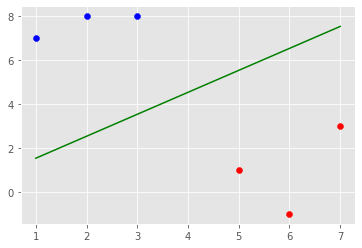

In [163]:
# Create 
x =np.linspace(1,7,3)
w = svm1.w
b = svm1.b
y = (-b-w[0]*x)/w[1]

plt.scatter(data_dict[-1][:,0],data_dict[-1][:,1],c="b")
plt.scatter(data_dict[1][:,0],data_dict[1][:,1],c="r")
plt.plot(x,y,c="green")
#plt.plot()
plt.show()

In [170]:
np.ones(4)*7687

array([7687., 7687., 7687., 7687.])

### Evaluate model in Banknote Authentication Dataset

In [152]:
features2 = ['date_numeric', 'Temperature','Humidity','Light','CO2','HumidityRatio',]

In [153]:
data_occupancy = {-1:train[train["Occupancy"]==0][features2].to_numpy(),
                  1:train[train["Occupancy"]==1][features2].to_numpy()
                 }

In [4]:
#svm_occupancy = Support_Vector_Machine(visualization=False)
#svm_occupancy.fit(data_occupancy)

In [ ]:
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),
             
             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

svm1 = Support_Vector_Machine(visualization=False)
svm1.fit(data_dict)

## SVM Implementation

In [29]:
df.shape

(1372, 5)

In [40]:
from sklearn.model_selection import train_test_split

train_set_df, test_set_df = train_test_split(df, test_size=0.2, random_state=42)

In [41]:
df.keys()

Index(['variance_of_Wavelet', 'skewness_of_Wavelet', 'curtosis_of_Wavelet',
       'entropy', 'class'],
      dtype='object')

In [42]:
X = train_set_df[['variance_of_Wavelet', 'skewness_of_Wavelet', 'curtosis_of_Wavelet','entropy']]
y = train_set_df['class']

In [51]:
X_test = test_set_df[['variance_of_Wavelet', 'skewness_of_Wavelet', 'curtosis_of_Wavelet','entropy']]
y_test = test_set_df['class']
y.shape

(1097,)

In [44]:
from sklearn import svm

In [45]:
clf = svm.SVC()
clf.fit(X, y)

SVC()

In [46]:
predicted_svm = clf.predict(X)
predicted_svm_test = clf.predict(X_test)

In [47]:
accuracy = accuracy_score(y, predicted_svm).round(2)
conf_matrix = confusion_matrix(y, predicted_svm)

In [48]:
print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy:  1.0
Confusion Matrix:
 [[609   5]
 [  0 483]]


In [49]:
accuracy_test = accuracy_score(y_test, predicted_svm_test).round(2)
conf_matrix_test = confusion_matrix(y_test, predicted_svm_test)

In [50]:
print("Accuracy: ", accuracy_test)
print("Confusion Matrix:\n", conf_matrix_test)

Accuracy:  1.0
Confusion Matrix:
 [[148   0]
 [  0 127]]


#### K-means for linear-separability (No sirve, pero el código de la matriz de confusión y la precisión sirve)

The Kmeans algorithms briefly consist in find the centroids which minimize the variance of each class with their associate centroid and divide groups using the Voronoi diagram. In our case, how is a binary classification task, then if data are linearly separable we should obtain a accurary nearly to 1 using this method  [5].

In [ ]:
X=df.drop(["class"],axis=1).values
kmeans = KMeans(n_clusters=2).fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
accuracy = accuracy_score(df["class"], labels).round(2)
conf_matrix = confusion_matrix(df["class"], labels)

print("Centroids:\n", centroids)

In [ ]:
print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

The previous results indicated us that the two classes are non linearly-separable data.

# References

[1] [Mathematics of Machine Learning (2023-01)](https://sites.google.com/site/fagomezj/matem%C3%A1ticas-del-aprendizaje-de-m%C3%A1quinas-2023?authuser=0), Francisco Gomez Website. <br>
[2] [Support Vector Machine Optimization in Python part 2](https://pythonprogramming.net/svm-optimization-python-2-machine-learning-tutorial/?completed=/svm-optimization-python-machine-learning-tutorial/), pythonprogramming. <br>
[3] [Banknote authentication data set](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#), UCI Machine Learning Repository. <br>
[4] [Detect forged banknotes using Artificial Intelligence](https://www.neuraldesigner.com/learning/examples/banknote-authentication), Neuraldesigner.<br>
[5] Elizondo, D., "The linear separability problem: some testing methods," in Neural Networks, IEEE Transactions on , vol.17, no.2, pp.330-344, March 2006 doi: 10.1109/TNN.2005.860871